In [1]:
import coiled

import fsspec
import numpy as np
import rioxarray
import xarray as xr
import fsspec
import pandas as pd
import logging
from flox.xarray import xarray_reduce
import dask

In [3]:
logging.getLogger("distributed.client").setLevel(logging.ERROR)  # or logging.ERROR

## Start the cluster

- Computation is sensitive to the cpu to memory ratio of instances
- Memory optimized instance type is best - using r7g.2xlarge (8vcpu and 64GB; 1:8 cpu to memory)
- Out of memory error on instances with low cpu to memory ratio (even 1:4)
- Graviton instances performed better than intel (and they are cheaper!)
- Notebook, the data and cluster are in the same region
- Using spot instances when available

In [ ]:
cluster = coiled.Cluster(
    name="grasslands_zonal_stat",
    region="us-east-1",
    n_workers=100,
    tags={"project": "dist_alerts_zonal_stat"},
    scheduler_vm_types="r7g.xlarge",
    worker_vm_types="r7g.xlarge",
    compute_purchase_option="spot_with_fallback"
)

client = cluster.get_client()

In [25]:
grasslands = xr.open_zarr("s3://gfw-data-lake/gfw_grasslands/v1/zarr/natural_grassland2kchunk.zarr").band_data
grasslands

<xarray.DataArray 'band_data' (year: 23, y: 528000, x: 1436000)> Size: 17TB
dask.array<open_dataset-band_data, shape=(23, 528000, 1436000), dtype=uint8, chunksize=(23, 4000, 4000), chunktype=numpy.ndarray>
Coordinates:
    spatial_ref  int64 8B ...
  * y            (y) float64 4MB 76.0 76.0 76.0 76.0 ... -56.0 -56.0 -56.0 -56.0
  * x            (x) float64 11MB -180.0 -180.0 -180.0 ... 179.0 179.0 179.0
  * year         (year) int64 184B 2000 2001 2002 2003 ... 2019 2020 2021 2022
Attributes:
    AREA_OR_POINT:  Area

In [32]:
xmin, xmax, ymin, ymax = (
    grasslands.coords['x'].min().item(), grasslands.coords['x'].max().item(),
    grasslands.coords['y'].min().item(), grasslands.coords['y'].max().item()
)

In [35]:
ymax

75.999875

In [26]:
pixel_area = xr.open_zarr(
    's3://gfw-data-lake/umd_area_2013/v1.10/raster/epsg-4326/zarr/pixel_area.zarr/'
).band_data.sel(x=slice(xmin, xmax), y=slice(ymax, ymin)).chunk({'x': 2000, 'y': 2000})


In [36]:
grasslands

<xarray.DataArray 'band_data' (year: 23, y: 528000, x: 1436000)> Size: 17TB
dask.array<open_dataset-band_data, shape=(23, 528000, 1436000), dtype=uint8, chunksize=(23, 4000, 4000), chunktype=numpy.ndarray>
Coordinates:
    spatial_ref  int64 8B ...
  * y            (y) float64 4MB 76.0 76.0 76.0 76.0 ... -56.0 -56.0 -56.0 -56.0
  * x            (x) float64 11MB -180.0 -180.0 -180.0 ... 179.0 179.0 179.0
  * year         (year) int64 184B 2000 2001 2002 2003 ... 2019 2020 2021 2022
Attributes:
    AREA_OR_POINT:  Area

In [ ]:
countries = xr.open_zarr(
    's3://gfw-data-lake/gadm_administrative_boundaries/v4.1.85/raster/epsg-4326/zarr/adm0.zarr'
).band_data.sel(x=slice(xmin, xmax), y=slice(ymax, ymin)).chunk({'x': 2000, 'y': 2000})

countries

In [ ]:
regions = xr.open_zarr(
    's3://gfw-data-lake/gadm_administrative_boundaries/v4.1.85/raster/epsg-4326/zarr/adm1.zarr'
).band_data.sel(x=slice(xmin, xmax), y=slice(ymax, ymin)).chunk({'x': 2000, 'y': 2000})
regions



In [ ]:
subregions = xr.open_zarr(
    's3://gfw-data-lake/gadm_administrative_boundaries/v4.1.85/raster/epsg-4326/zarr/adm2.zarr'
).band_data.sel(x=slice(xmin, xmax), y=slice(ymax, ymin)).chunk({'x': 2000, 'y': 2000})
subregions

In [ ]:
adm0_ids = [
    4, 8, 10, 12, 16, 20, 24, 28, 31, 32, 36, 40, 44, 48, 50, 51, 52, 56, 60,
    64, 68, 70, 72, 74, 76, 84, 86, 90, 92, 96, 100, 104, 108, 112, 116, 120,
    124, 132, 136, 140, 144, 148, 152, 156, 158, 162, 166, 170, 174, 175, 178,
    180, 184, 188, 191, 192, 196, 203, 204, 208, 212, 214, 218, 222, 226, 231,
    232, 233, 234, 238, 239, 242, 246, 248, 250, 254, 258, 260, 262, 266, 268,
    270, 275, 276, 288, 292, 296, 300, 304, 308, 312, 316, 320, 324, 328, 332,
    334, 336, 340, 344, 348, 352, 356, 360, 364, 368, 372, 376, 380, 384, 388,
    392, 398, 400, 404, 408, 410, 414, 417, 418, 422, 426, 428, 430, 434, 438,
    440, 442, 446, 450, 454, 458, 462, 466, 470, 474, 478, 480, 484, 492, 496,
    498, 499, 500, 504, 508, 512, 516, 520, 524, 528, 531, 533, 534, 535, 540,
    548, 554, 558, 562, 566, 570, 574, 578, 580, 581, 583, 584, 585, 586, 591,
    598, 600, 604, 608, 612, 616, 620, 624, 626, 630, 634, 638, 642, 643, 646,
    652, 654, 659, 660, 662, 663, 666, 670, 674, 678, 682, 686, 688, 690, 694,
    702, 703, 704, 705, 706, 710, 716, 724, 728, 729, 732, 740, 744, 748, 752,
    756, 760, 762, 764, 768, 772, 776, 780, 784, 788, 792, 795, 796, 798, 800,
    804, 807, 818, 826, 831, 832, 833, 834, 840, 850, 854, 858, 860, 862, 876,
    882, 887, 894
]


In [ ]:
grasslands.coords['x'] = pixel_area.coords['x']
grasslands.coords['y'] = pixel_area.coords['y']

In [ ]:
pixel_area = pixel_area.drop_vars('band').squeeze()
grasslands_only = (grasslands == 2).astype(np.uint8)

grasslands_areas = grasslands_only * pixel_area

## Computation

In [ ]:
%%time

from flox import ReindexArrayType, ReindexStrategy


grasslands.name = "grasslands"
countries.name = "countries"
regions.name = "regions"
subregions.name = "subregions"


gadm_grassland_area = xarray_reduce(
    grasslands_areas
    *(
        countries,
        regions,
        subregions,
    ),
    func='sum',
    expected_groups=(
        adm0_ids,
        np.arange(1, 86),
        np.arange(1, 854),
    ),
    reindex=ReindexStrategy(
        blockwise=False, array_type=ReindexArrayType.SPARSE_COO
    ),
    fill_value=0
).compute()

## Transforming sparse array to dataframe and saving to parquet

In [ ]:
sparse_data = gadm_grassland_area.data

dim_names = gadm_grassland_area.dims
indices = sparse_data.coords
values = sparse_data.data

coord_dict = {
    dim: gadm_grassland_area.coords[dim].values[indices[i]]
    for i, dim in enumerate(dim_names)
}
coord_dict["grassland_area"] = values

df = pd.DataFrame(coord_dict)

In [5]:
numeric_to_alpha3 = {
    4: 'AFG', 248: 'ALA', 8: 'ALB', 12: 'DZA', 16: 'ASM', 20: 'AND', 24: 'AGO', 660: 'AIA',
    10: 'ATA', 28: 'ATG', 32: 'ARG', 51: 'ARM', 533: 'ABW', 36: 'AUS', 40: 'AUT', 31: 'AZE',
    44: 'BHS', 48: 'BHR', 50: 'BGD', 52: 'BRB', 112: 'BLR', 56: 'BEL', 84: 'BLZ', 204: 'BEN',
    60: 'BMU', 64: 'BTN', 68: 'BOL', 535: 'BES', 70: 'BIH', 72: 'BWA', 74: 'BVT', 76: 'BRA',
    86: 'IOT', 96: 'BRN', 100: 'BGR', 854: 'BFA', 108: 'BDI', 132: 'CPV', 116: 'KHM', 120: 'CMR',
    124: 'CAN', 136: 'CYM', 140: 'CAF', 148: 'TCD', 152: 'CHL', 156: 'CHN', 162: 'CXR', 166: 'CCK',
    170: 'COL', 174: 'COM', 178: 'COG', 180: 'COD', 184: 'COK', 188: 'CRI', 384: 'CIV', 191: 'HRV',
    192: 'CUB', 531: 'CUW', 196: 'CYP', 203: 'CZE', 208: 'DNK', 262: 'DJI', 212: 'DMA', 214: 'DOM',
    218: 'ECU', 818: 'EGY', 222: 'SLV', 226: 'GNQ', 232: 'ERI', 233: 'EST', 748: 'SWZ', 231: 'ETH',
    238: 'FLK', 234: 'FRO', 242: 'FJI', 246: 'FIN', 250: 'FRA', 254: 'GUF', 258: 'PYF', 260: 'ATF',
    266: 'GAB', 270: 'GMB', 268: 'GEO', 276: 'DEU', 288: 'GHA', 292: 'GIB', 300: 'GRC', 304: 'GRL',
    308: 'GRD', 312: 'GLP', 316: 'GUM', 320: 'GTM', 831: 'GGY', 324: 'GIN', 624: 'GNB', 328: 'GUY',
    332: 'HTI', 334: 'HMD', 336: 'VAT', 340: 'HND', 344: 'HKG', 348: 'HUN', 352: 'ISL', 356: 'IND',
    360: 'IDN', 364: 'IRN', 368: 'IRQ', 372: 'IRL', 833: 'IMN', 376: 'ISR', 380: 'ITA', 388: 'JAM',
    392: 'JPN', 832: 'JEY', 400: 'JOR', 398: 'KAZ', 404: 'KEN', 296: 'KIR', 408: 'PRK', 410: 'KOR',
    414: 'KWT', 417: 'KGZ', 418: 'LAO', 428: 'LVA', 422: 'LBN', 426: 'LSO', 430: 'LBR', 434: 'LBY',
    438: 'LIE', 440: 'LTU', 442: 'LUX', 446: 'MAC', 450: 'MDG', 454: 'MWI', 458: 'MYS', 462: 'MDV',
    466: 'MLI', 470: 'MLT', 584: 'MHL', 474: 'MTQ', 478: 'MRT', 480: 'MUS', 175: 'MYT', 484: 'MEX',
    583: 'FSM', 498: 'MDA', 492: 'MCO', 496: 'MNG', 499: 'MNE', 500: 'MSR', 504: 'MAR', 508: 'MOZ',
    104: 'MMR', 516: 'NAM', 520: 'NRU', 524: 'NPL', 528: 'NLD', 540: 'NCL', 554: 'NZL', 558: 'NIC',
    562: 'NER', 566: 'NGA', 570: 'NIU', 574: 'NFK', 807: 'MKD', 580: 'MNP', 578: 'NOR', 512: 'OMN',
    586: 'PAK', 585: 'PLW', 275: 'PSE', 591: 'PAN', 598: 'PNG', 600: 'PRY', 604: 'PER', 608: 'PHL',
    612: 'PCN', 616: 'POL', 620: 'PRT', 630: 'PRI', 634: 'QAT', 638: 'REU', 642: 'ROU', 643: 'RUS',
    646: 'RWA', 652: 'BLM', 654: 'SHN', 659: 'KNA', 662: 'LCA', 663: 'MAF', 666: 'SPM', 670: 'VCT',
    882: 'WSM', 674: 'SMR', 678: 'STP', 682: 'SAU', 686: 'SEN', 688: 'SRB', 690: 'SYC', 694: 'SLE',
    702: 'SGP', 534: 'SXM', 703: 'SVK', 705: 'SVN', 90: 'SLB', 706: 'SOM', 710: 'ZAF', 239: 'SGS',
    728: 'SSD', 724: 'ESP', 144: 'LKA', 729: 'SDN', 740: 'SUR', 744: 'SJM', 752: 'SWE', 756: 'CHE',
    760: 'SYR', 158: 'TWN', 762: 'TJK', 834: 'TZA', 764: 'THA', 626: 'TLS', 768: 'TGO', 772: 'TKL',
    776: 'TON', 780: 'TTO', 788: 'TUN', 792: 'TUR', 795: 'TKM', 796: 'TCA', 798: 'TUV', 800: 'UGA',
    804: 'UKR', 784: 'ARE', 826: 'GBR', 840: 'USA', 581: 'UMI', 858: 'URY', 860: 'UZB', 548: 'VUT',
    862: 'VEN', 704: 'VNM', 92: 'VGB', 850: 'VIR', 876: 'WLF', 732: 'ESH', 887: 'YEM', 894: 'ZMB',
    716: 'ZWE'
}

In [6]:
df['countries'] = df.countries.apply(lambda x: numeric_to_alpha3[x])

In [7]:
df['grassland_area'] = df.grassland_area / 1e4

In [8]:
df.to_parquet(
    's3://gfw-data-lake/gfw_grasslands/v1/zarr/gadm_grasslands_areas.parquet',
    index=False
)

<Axes: xlabel='year'>

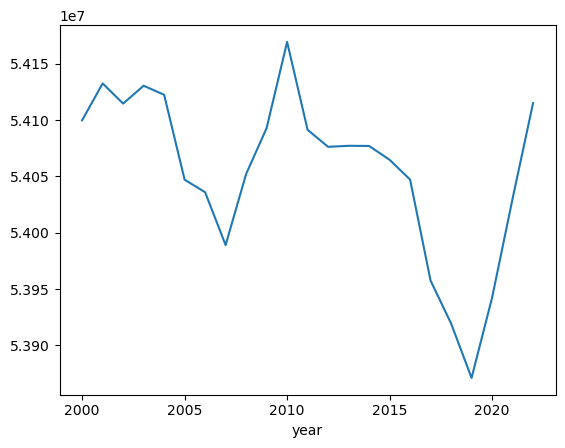

In [55]:
df[df.countries == 'NAM'].groupby(by='year').grassland_area.sum().plot()

<Axes: xlabel='year'>

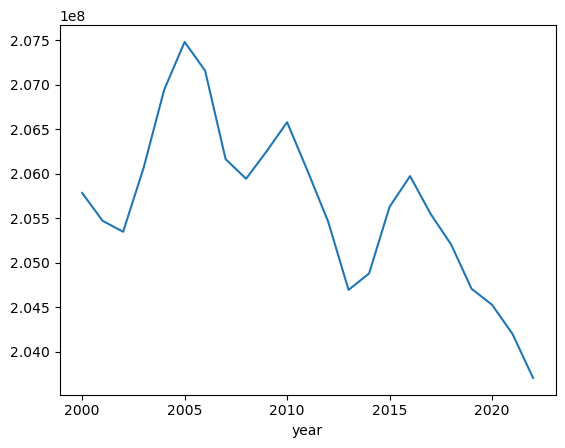

In [12]:
df[df.countries == 'KAZ'].groupby(by='year').grassland_area.sum().plot()